# Relations as Graphs - Network Analysis

<a href="../../_slides/chapter-15-slides.html">See also the slides that summarize a portion of this content.</a>


## What is a graph?

In mathematics, the word *graph* has two meanings.

 * **Meaning #1 (more common):** The graph of a function on the ordinary Cartesian plane of $x$ and $y$ axes.
 * **Meaning #2 (less common):** A visualization of an interconnected network of objects.

We're focused on the second meaning here.  In such a network, the objects being connected are called *nodes* or *vertices,* and the connections are called *edges,* *arrows,* or *links.*  While we call it a graph in mathematics, data scientists might refer to it instead as *network data.*

Let's start with a small, pretend example.  Let's say we spoke to five friends and asked them which of the others they'd turn to for advice about an important life decision.  We could depict their answers with a visualization like the following.

![Image of five ovals, labeled Augustus, Beatriz, Cyrano, Dauphine, Englebert, some connected in pairs by arrows](_images/friends-graph.png)

The five friends are the graph's *vertices,* and are drawn with ovals in the image.  The connections among them are the graph's *edges,* representing the friends' answers to the question about advice.  For instance, the arrow from Augustus to Cyrano says that Augustus would consult Cyrano when needing advice about an important life decision, but the absence of an arrow from Beatriz to Englebert means that she would not consult him.

Now that we've seen a small (but pretend) example, let's consider some more realistic examples.

 * To prepare for class, you were asked to consider a spreadsheet recording shipping records between every two U.S. states in the year 1997.  In that data, the vertices were the 50 states and the edges were the records of how much money (or weight) of goods were shipped.
 * In this chapter, we'll look at a spreadsheet created by marine biologists recording the interaction among a community of dolphins living off Doubtful Sound in New Zealand.  The vertices of that network are the dolphins and the edges represent social interactions among them.  (The data comes from [Mark Newman's website](http://www-personal.umich.edu/~mejn/netdata/), which cites the biologists who collected it.)
 * One of the largest examples of network data has as its vertices the collection of all pages on the internet, and edges are links between them.  Google does linear algebra-based computations on this enormous graph regularly, to update their search engine to reflect the latest changes on the web.

```{admonition} Big Picture - A graph depicts a binary relation of a set with itself
---
class: alert alert-primary
---
Notice that a graph is nothing but a picture representing a *binary relation,* a term we first defined in [the notes on Chapter 2](chapter-2-mathematical-foundations).  In the case of a graph, the two sets involved in the relation are actually the same set, even though that's not a requirement for binary relations in general.  In the examples above, we connected friends to friends for advice, and states to states with shipping information, and pages to pages with hyperlinks.  In a graph, the relation connects the set of vertices to itself, not to some other set.
```

The graph of five friends shown above is a *directed graph,* because the edges have arrowheads to indicate that they make sense in only one direction.  While Augustus said he would seek advice from Cyrano, Cyrano did not say the same about Augustus.

In an *undirected graph,* every connection goes in both directions.  For instance, the relation recorded in the dolphin data is about spending time together.  If dolphin A is spending time with dolphin B, then the reverse is obviously also true.  So in the dolphin data, all connections go in both directions, and we can thus draw them without arrowheads; they are all "two-way streets."

## Storing graphs in tables

In our course, we store almost all of our data in tables, such as pandas DataFrames, CSV files, etc.  How can a graph be represented in a table?  There are two primary ways.

First, we can use an *adjacency matrix,* which is a table that tells which pairs of vertices are adjacent.  Its row headings are the vertices in the network, and the column headings are the same vertices again.  Each entry says whether the row connects to the column.  Here's the adjacency matrix for the five friends graph shown above.

|               | Augustus | Beatriz | Cyrano | Dauphine | Englebert |
|---------------|----------|---------|--------|----------|-----------|
| **Augustus**  |  False   |  False  |  True  |   False  |   False   |
| **Beatriz**   |  False   |  False  |  True  |   False  |   False   |
| **Cyrano**    |  False   |  True   |  False |   False  |   True    |
| **Dauphine**  |  False   |  False  |  True  |   False  |   False   |
| **Englebert** |  True    |  True   |  False |   False  |   False   |

Order is important here.  If we want to know whether Augustus $\to$ Cyrano, we must look in the Augustus **row** and the Cyrano **column.**  (This is not hard to remember, because the row headings are actually visually to the left of the column headings, which fits the "row $\to$ column" orientation of the arrow.)

Alternately, we could represent a relation the way we've discussed in [Chapter 2](chapter-2-mathematical-foundations).  We can just store in a table the list of pairs that make up the relation.  Each row in such a table represents an arrow in the graph.  For the five friends, that table looks like the following.

|   From    |     To    |
|-----------|-----------|
| Augustus  |  Cyrano   |
|  Beatriz  |  Cyrano   |
|  Cyrano   |  Beatriz  |
|  Cyrano   | Englebert |
| Dauphine  |  Cyrano   |
| Englebert | Augustus  |
| Englebert |  Beatriz  |

Or we could name the columns something more descriptive, such as "Advice seeker" and "Advice giver."  I chose "From" and "To" to show that a similar table could be used to store any directed graph data.

We will call this kind of two-column table a *list of ordered pairs,* because the ordering of each pair of vertices often matters.  An edge from Augustus to Cyrano does not mean the same thing as an edge from Cyrano to Augustus.  We can also call it an *edge list,* because the connections in a graph are called edges.

```{admonition} Big Picture - How pivoting/melting impacts graph data
---
class: alert alert-primary
---
These two ways to store the data are very related.  If we just imagine a third column for this last table, "From," "To," and "Connected (True/False)," then the two tables could be converted from one to the other using pivot and melt from [Chapter 6 of the course notes](chapter-6-single-table-verbs).  In that chapter, we learned that it is typically easier for a computer to process melted (tall) data, but easier for humans to read pivoted (wide) data.  To make our computations easier, we will work with this second, two-column form.
```

But storing network data as a table of edges does have one small disadvantage:  It doesn't make it obvious what the complete set of vertices is.  For instance, just given the second (tall) table shown above, we can't be sure how many friends there are.  Is it just these five, or is there a sixth friend, or a seventh?  Imagine another friend, Fatima, who has unusual opinions, so she wouldn't go to any of the friends for advice, nor would they go to her.  She wouldn't show up in any of the edges, so we wouldn't see her in the data.

Thus if we store a graph as an edge list, we will also need a separate list of the graph's vertices.  That list will include every vertex mentioned in the edge list, and possibly some others.

## Loading network data

### Dolphin dataset

I've included the dolphin community data with these course notes.  <a href='../../_static/dolphins.xlsx'>You can download it here</a> (as an Excel workbook).  I'll explore it below to show you how it's structured.

First, what sheets are stored in the workbook?

In [1]:
import pandas as pd
sheets = pd.read_excel( '_static/dolphins.xlsx', sheet_name=None )
sheets.keys()

dict_keys(['ids_and_names', 'relationships'])

There are two sheets in the workbook, one called `"ids_and_names"` and one called `"relationships"`.  Let's take a look at both.

In [2]:
df1 = sheets['ids_and_names']
df1.head()

,id,name
0,0,Beak
1,1,Beescratch
2,2,Bumper
3,3,CCL
4,4,Cross


In [3]:
df2 = sheets['relationships']
df2.head()

,source,target
0,8,3
1,9,5
2,9,6
3,10,0
4,10,2


It seems as if the first sheet gives each dolphin, by name, a unique ID, while the second sheet shows the social connections of which dolphins spend time with which other ones.  This is just how we discussed storing the data above; there is a list of vertices in the first table and a list of edges in the second table.

But the data is not formatted conveniently.  The second table would be more convenient if it included dolphin names instead of IDs.  Let's use Python dictionaries and `replace()` to fix it.

In [4]:
convert_id_to_name = dict( zip( df1.id, df1.name ) )
df2.replace( convert_id_to_name, inplace=True )
df2.head()

,source,target
0,Double,CCL
1,Feather,DN16
2,Feather,DN21
3,Fish,Beak
4,Fish,Bumper


### Python's NetworkX module

The `networkx` module is pospular for working with network data in Python.  You might already have it installed:

 * If you're using Deepnote, then when you attempt to import NetworkX using the code below, Deepnote will prompt you to install it first; just follow the prompts.
 * If you're using Google Colab, NetworkX is pre-installed there.
 * If you installed Python on your own computer through any of the methods described in [Chapter 3](chapter-3-jupyter) (including Anaconda or VSCode with Docker), that included NetworkX.
 * If you have a non-Anaconda Python setup on your machine, you can install NetworkX with `pip install networkx`.

The standard way to import NetworkX into your notebook or script is using the abbreviation `nx`.

In [5]:
import networkx as nx

This module lets us turn tables of data (like the edge list for dolphins we just saw) into Python `Graph` objects, which we can use for both computation and visualization.  The first step in creating a `Graph` object is always the same; just call the `nx.Graph()` function and it will create a new, empty graph with no vertices and no edges.

In [6]:
dolphins = nx.Graph()

We will now add vertices and edges to that graph.  Let's start with the vertices.  Each NetworkX `Graph` object lets you add vertices with the function `add_nodes_from(your_list)`.  We will use that function to add all the dolphin names to our graph.  We can even check the size of the graph to be sure it worked.

In [7]:
dolphins.add_nodes_from( df1.name )  # the column of all dolphin names
len( dolphins )                      # how many nodes do we have now?

62

Similarly, we can add edges with the function `add_edges_from(your_list)`, but the list must be a list of ordered pairs.  For instance, in our dolphin data case, we'd want it to be something like `[('Double','CCL'),('Feather','DN16'),('Feather','DN21'),...]` and so on.  But we don't want to have to type out the entire dolphin relationships table as ordered pairs; it's too big!

In [8]:
len( df2 )

159

Fortunately, we can use the same trick we do when creating a dictionary from two columns.  Recall that `zip()` takes two columns and converts them into a list of pairs; we often used this to create a dictionary with the trick `dict(zip(df.col1,df.col2))`.  We can use it with `list()` instead of `dict()` to create a list of the ordered pairs rather than a dictionary.

In [9]:
edges = list( zip( df2.source, df2.target ) )  # get the list of edges
edges[:10]                                     # see if we did it right

[('Double', 'CCL'),
 ('Feather', 'DN16'),
 ('Feather', 'DN21'),
 ('Fish', 'Beak'),
 ('Fish', 'Bumper'),
 ('Gallatin', 'DN16'),
 ('Gallatin', 'DN21'),
 ('Gallatin', 'Feather'),
 ('Grin', 'Beak'),
 ('Grin', 'CCL')]

It looks like we did.  Let's add these to the dolphin graph.

In [10]:
dolphins.add_edges_from( edges )

We now have our dolphin data loaded into a NetworkX `Graph` object.  This enables both computation and visualization, and we'll consider each of those in its own section, below.

## Computations on graphs

There are a great many computations that can be done on graphs; we will only scratch the surface here.  You can learn more about graphs in MA267 at Bentley, and you can learn more about the capabilities of the NetworkX module through its documentation, [here](https://networkx.github.io/documentation/).  But this section gives a few example computations that make sense for network data.

We can ask how dense the network is, which is a measure of what proportion of its possible connections it actually has.

In [11]:
nx.density( dolphins )

0.08408249603384453

Of all the possible social relationships among the dolphins (every possible pair that might hang out together), this network has only about 8.4% of those connections.

The number of connections any one particular dolphin has is called the *degree* of that vertex.  We can ask for a histogram of the degrees across the network.

In [12]:
nx.degree_histogram( dolphins )

[0, 9, 6, 6, 5, 8, 8, 7, 4, 4, 2, 2, 1]

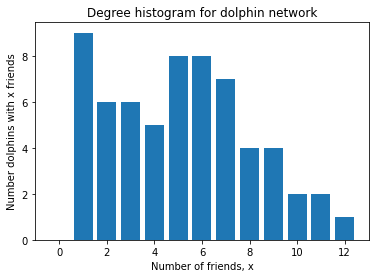

In [13]:
import matplotlib.pyplot as plt
degrees = nx.degree_histogram( dolphins )
plt.bar( x=range(len(degrees)), height=degrees )
plt.xlabel( 'Number of friends, x' )
plt.ylabel( 'Number dolphins with x friends' )
plt.title( 'Degree histogram for dolphin network' )
plt.show()

As you can see, no dolphin had zero friends, and thus we know that all dolphins appeared in some edge in the network.

We see that some dolphins had many more social associations.  If this were a network of humans, we might ask which people were the most influential in the social network.  There are many ways to measure influence.  One way is by a notion called "betweenness," which considers all the paths through which information might flow in a network, and asks which vertices are on the largest proportion of those paths.  This measure is called "betweenness centrality" and can be used to rank the vertices in a network by a measure of their importance.

Although it doesn't make a lot of sense to measure this for dolphins (as opposed to humans), the code below illustrates how do to the computation.

In [14]:
bc = nx.betweenness_centrality( dolphins )  # this is a big dictionary
bc = pd.Series( bc )                        # now it's a pandas Series
bc.sort_values( ascending=False ).head()    # let's see the top values

SN100         0.248237
Beescratch    0.213324
SN9           0.143150
SN4           0.138570
DN63          0.118239
dtype: float64

Although the particular numbers don't have units we can easily interpret, higher numbers are vertices that sit along a higher proportion of the network's pathways.  There are many other ways to measure important nodes in a network; these are called centrality measures, and the full list of ways that NetworkX supports them appears [here](https://networkx.github.io/documentation/stable/reference/algorithms/centrality.html).

```{admonition} Learning on Your Own - Centrality Measures
---
class: alert alert-danger
---
Choose 3 centrality measures from the documentation linked to in the previous paragraph.  Write a brief report or slide deck for your classmates that provides the following information for each of the three measures you chose.

 1. the purpose/intent behind the measure
 2. the formula for the measure
 3. the Python code for using that measure it on a NetworkX `Graph` object
```

Let us turn now to how we can visualize the dolphin network.

## Visualization of graphs

### Drawing the dolphin network

The NetworkX module has a small number of graph-drawing features, but they will be sufficient for our needs here.  The simplest method is to just call `nx.draw( your_graph )`, but there are many options to help make it more attractive.  The simplest form of the dolphin network looks like this.

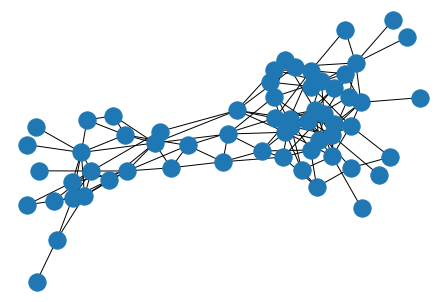

In [15]:
nx.draw( dolphins )

While this shows us the general structure of the 62 dolphins involved, there's a lot it doesn't answer.  But first, let's notice what we can from this picture.

On one side of the graph, we see a dense cluster of about 20-30 dolphins who seem very social, and interact with one another more than most other dolphins in the network.  There is a smaller cluster of about 10 or so on the other side that are also densely connected.  Other than that, most dolphins have relatively few social connections.  The dolphins in the center are an indirect social bridge between the two groups.  But which dolphins are they?  The vertices in the graph aren't labeled.

The `nx.draw()` function takes many optional parameters, and you can see them all [here](https://networkx.github.io/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw_networkx.html).  In this case, we might want to label the vertices with the name of the dolphin, and increase the size of the figure.

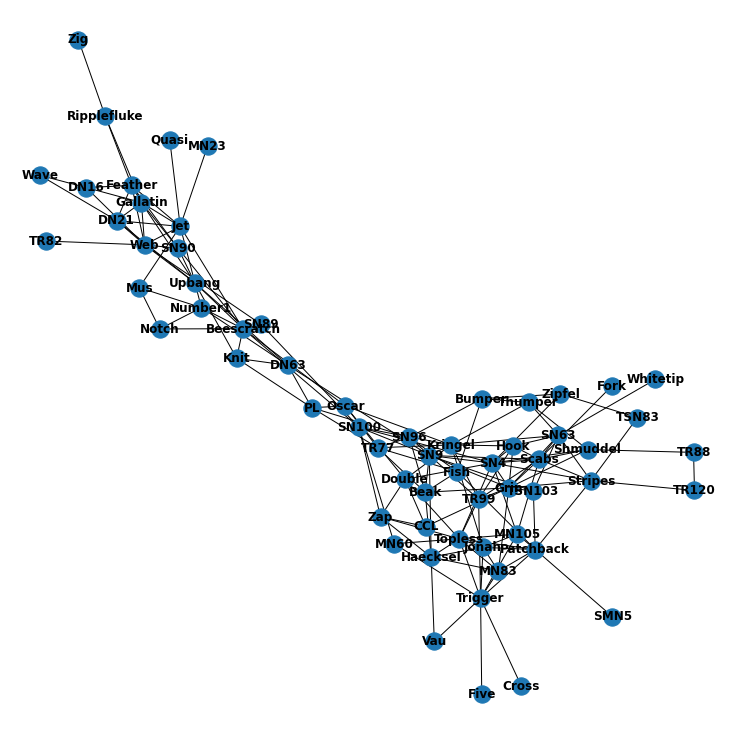

In [16]:
plt.figure( figsize=(10,10) )  # 10in x 10in
nx.draw( dolphins, with_labels=True, font_weight="bold" )
plt.show()

Because it is often difficult to lay out a graph in an attractive way on a two-dimensional drawing, there is some random experimentation involved in most network drawing algorithms, including the one used by NetworkX.  So we see that the layout of the vertices is not exactly the same.  The two clusters of dolphins may not be laid out in the same locations or orientations in this graph and in the previous one.  In fact, every time I run the code, it looks a little different!

### Better drawing tools

NetworkX emphasizes that there are much more powerful graph-drawing software packages available.  For instance, you might download [Gephi](https://gephi.org/) or [Cytoscape](https://cytoscape.org/) if you need to make more aesthetically pleasing images from your network data.  To export your network from Python to that software, use the following code.

```python
nx.write_graphml( dolphins, 'dolphins.graphml' )
```

You can then import the `dolphins.graphml` file into either of those other pieces of software to visualize it more conveniently.  Similarly, if you have data exported from either of those pieces of software that you want to bring into Python for use with NetworkX, you can use the [`nx.read_graphml()` function](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.readwrite.graphml.read_graphml.html).

```{admonition} Learning on Your Own - Gephi
---
class: alert alert-danger
---
 1. Obtain some large network data.  One easy option is to use the shipping data that you prepared for class today.
 2. Export that network data in GraphML format, as described above.
 3. Download and install [Gephi](https://gephi.org/).
 4. Import the data into Gephi and try visualizing it.
 5. Create a tutorial with instructions and screenshots that teaches the process to your classmates.
```

```{admonition} Learning on Your Own - Cytoscape
---
class: alert alert-danger
---
This exercise is the same as the previous one, but using [Cytoscape](https://cytoscape.org/) instead of Gephi.
```

### Drawing larger networks

The dolphin network was fairly small (62 vertices) and fairly sparse (most dolphins socializing with only a few others).  But a larger or more dense network will be much harder to visualize, because there will be too many vertices or edges to draw in a way that a human can make sense of.  We will see an example of this in class when we consider the shipping data mentioned at the start of this chapter.  In that situation, we will find it useful to sort the connections in the network based on some information about them (like the amount shipped), and draw only the most important connections.

## Directed draphs in NetworkX

The beginning of this chapter distinguished directed graphs (like the friends network, where arrows went one way only) from undirected graphs (like the dolphins network, where each relationship was reciprocal).  To work with a directed graph in NetworkX, there are a few changes to what we learned above.

First, you create a directed graph not with `nx.Graph()` but with `nx.DiGraph()`.

In [17]:
friends = nx.DiGraph()

But we can add vertices and edges exactly the same way as we did with the dolphins.

In [18]:
friends.add_nodes_from( [ 'Augustus', 'Beatriz', 'Cyrano', 'Dauphine', 'Englebert' ] )
friends.add_edges_from( [
    ('Augustus', 'Cyrano'),
    ('Beatriz', 'Cyrano'),
    ('Cyrano', 'Beatriz'),
    ('Cyrano', 'Englebert'),
    ('Dauphine', 'Cyrano'),
    ('Englebert', 'Augustus'),
    ('Englebert', 'Beatriz')
] )

However, some computations make sense only in the context of a directed graph.  For instance, we can measure the *reciprocity* of a directed graph, which asks how many of its edges are two-directional.  In the friends case, only the Beatriz$\to$Cyrano connection is reciprocated (Cyrano$\to$Beatriz); all the others are one-directional.  So we expect a low proportion as the result.

In [19]:
nx.reciprocity( friends )

0.2857142857142857

There are seven edges in the network, and two of them are part of a reciprocated relationship, so the reciprocity is $\frac27\approx0.285714$.

We can draw directed graphs using the same tools as we used for undirected graphs.

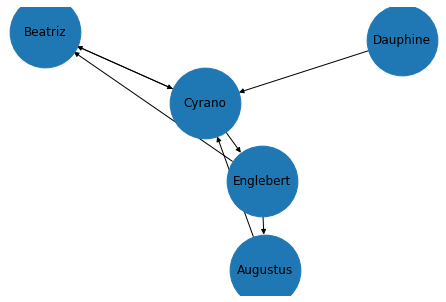

In [20]:
nx.draw( friends, with_labels=True, node_size=5000 )

If you plan to use network data in your final project for this course and would like to learn more about the power of NetworkX, including both computations and visualizations, I recommend Chapter 8 of [this book](https://link.springer.com/book/10.1007/978-3-319-50017-1).